In [1]:
import math
from scipy.special import comb
from scipy.stats import binom
import matplotlib.pyplot as plt
import numpy as np

# --- Helper Functions ---

def prob_binomial_pmf(k, n_trials, prob_success):
    """
    Computes the probability mass function of a binomial distribution B(n_trials, prob_success) at k.
    P(X=k) = C(n_trials, k) * prob_success^k * (1-prob_success)^(n_trials-k)
    """
    if k < 0 or k > n_trials:
        return 0.0
    # Handle edge cases for p=0 or p=1 if binom.pmf doesn't cover them as expected
    if prob_success == 0:
        return 1.0 if k == 0 else 0.0
    if prob_success == 1:
        return 1.0 if k == n_trials else 0.0
    return binom.pmf(k, n_trials, prob_success)

def prob_at_least_m_heads_in_j_flips(m_min_heads, j_flips, p_head):
    """
    Computes P(N_Hj >= m_min_heads), the probability of getting at least m_min_heads in j_flips.
    This is the P(C) term in the document.
    """
    if m_min_heads > j_flips:
        return 0.0
    if m_min_heads < 0: # Assuming m is non-negative as per typical binomial context
        m_min_heads = 0
    
    prob_sum = 0.0
    for i in range(m_min_heads, j_flips + 1):
        prob_sum += prob_binomial_pmf(i, j_flips, p_head)
    return prob_sum

def prob_x_heads_in_j_given_at_least_m(x_heads, m_min_heads, j_flips, p_head, prob_C_val=None):
    """
    Computes P(N_Hj = x_heads | N_Hj >= m_min_heads). This is q(x) in the document.
    """
    if x_heads < m_min_heads or x_heads > j_flips:
        return 0.0
    
    if prob_C_val is None:
        prob_C_val = prob_at_least_m_heads_in_j_flips(m_min_heads, j_flips, p_head)
    
    if prob_C_val == 0:
        # If the condition C is impossible, conditional probability is typically 0 or undefined.
        # Returning 0 if the specific x_heads is part of an impossible condition.
        return 0.0
        
    numerator = prob_binomial_pmf(x_heads, j_flips, p_head)
    return numerator / prob_C_val

def prob_first_passage_time(t_prime, A_target, p_plus_one_step):
    """
    Computes g(t', A), the probability that a 1D random walk starting from 0
    first reaches state A_target at step t_prime.
    p_plus_one_step is the probability of a +1 step (denoted as p in the document for heads).
    """
    if t_prime <= 0:
        return 0.0
    
    p_minus_one_step = 1.0 - p_plus_one_step

    if A_target == 0:
        # First return to 0
        if t_prime % 2 != 0 or t_prime < 2: # Must be an even number of steps, and at least 2
            return 0.0
        N = t_prime // 2
        if N < 1: # Should be caught by t_prime < 2
             return 0.0
        
        # Formula: g(2N, 0) = (2/N) * C(2N-2, N-1) * (p*(1-p))^N
        # Note: Some sources use (1/ (2N-1)) * C(2N-1, N) * (something) or related to Catalan.
        # The formula from the document is (abs(A)/t') * P(S_t' = A).
        # For A=0, this is ambiguous. The specific formula for A=0 provided is:
        # g(2N, 0) = (2/N) * C(2N-2, N-1) * (p*(1-p))^N
        # This is 2 * P(S_{2N}=0, S_i != 0 for i < 2N) / (2N) * (something)
        # It's (1/(N-1+N)) * C(2N-2,N-1) * p^N*(1-p)^N * 2 / (2N) * ? No.
        # Let's use the provided formula directly: (2/N) * C(2N-2, N-1) * (p(1-p))^N
        if N == 0: return 0.0 # t_prime would be 0, caught earlier
        
        # Handle C(0,0) for N=1 (t_prime=2)
        if 2 * N - 2 < 0 or N - 1 < 0 or 2 * N - 2 < N - 1 : # handles N=0 or N=1 for C(0,-1) etc.
             if N==1: # C(0,0) = 1
                 term_binom = 1 
             else: # Should not happen if N >= 1
                 return 0.0
        else:
             term_binom = comb(2 * N - 2, N - 1, exact=True)
        
        # Handle p=0 or p=1 for (p*(1-p))^N
        if p_plus_one_step == 0 or p_plus_one_step == 1:
            term_prob_product = 0.0 # (0*1)^N = 0 for N>=1
        else:
            term_prob_product = (p_plus_one_step * p_minus_one_step)**N
        
        if term_prob_product == 0 and N > 0: # if p=0 or p=1, cannot return to 0 unless stuck at 0 (not a walk)
            return 0.0

        return (2 / N) * term_binom * term_prob_product
    
    else: # A_target != 0
        # First passage to A_target
        if t_prime < abs(A_target): # Must take at least |A| steps
            return 0.0
        # t_prime and A_target must have the same parity
        if (t_prime % 2) != (abs(A_target) % 2):
            return 0.0
        
        # (t_prime + A_target) must be even and non-negative for (t_prime + A_target)/2 to be an integer number of +1 steps.
        # This implies (t_prime + A_target)/2 is num_plus_steps.
        # (t_prime - A_target)/2 is num_minus_steps.
        
        num_plus_steps_float = (t_prime + A_target) / 2.0
        num_minus_steps_float = (t_prime - A_target) / 2.0

        # These must be non-negative integers
        if num_plus_steps_float < 0 or num_minus_steps_float < 0:
            return 0.0
        if not num_plus_steps_float.is_integer() or not num_minus_steps_float.is_integer():
             # This should be covered by parity check, but as a safeguard:
            return 0.0
            
        num_plus_steps = int(num_plus_steps_float)
        num_minus_steps = int(num_minus_steps_float) # num_minus_steps = t_prime - num_plus_steps

        # Binomial term: C(t_prime, num_plus_steps)
        # This is P(S_t' = A_target) = C(t', (t'+A)/2) * p^((t'+A)/2) * (1-p)^((t'-A)/2)
        # The probability of *first* passage is (|A_target|/t_prime) * P(S_t' = A_target)
        
        prob_S_t_prime_equals_A = prob_binomial_pmf(num_plus_steps, t_prime, p_plus_one_step)
        
        return (abs(A_target) / t_prime) * prob_S_t_prime_equals_A


In [15]:
# --- Main Functions for Each Question ---

def q1a_expected_total_heads(n_total_flips, p_head, m_min_heads_in_j, j_first_flips):
    """
    Calculates the expected total number of heads in n_total_flips, conditional on having
    at least m_min_heads_in_j heads in the first j_first_flips. (Question 1a)
    
    E[N_H | C] = E[N_Hj | C] + E[N_H,n-j | C]
    E[N_H,n-j | C] = (n-j)p
    E[N_Hj | C] = sum_{x=m to j} [x * P(N_Hj=x)] / P(N_Hj >= m)
    """
    if not (0 <= j_first_flips <= n_total_flips and m_min_heads_in_j >= 0):
        raise ValueError("Invalid input parameters for q1a.")

    # Calculate P(C) = P(N_Hj >= m_min_heads_in_j)
    prob_C = prob_at_least_m_heads_in_j_flips(m_min_heads_in_j, j_first_flips, p_head)
    
    if prob_C == 0:
        # If the condition C can never be met, the conditional expectation is undefined.
        return float('nan') 
        
    # Calculate E[N_Hj | C]: Numerator part
    sum_x_prob_NHj_is_x = 0.0
    for x_val in range(m_min_heads_in_j, j_first_flips + 1):
        sum_x_prob_NHj_is_x += x_val * prob_binomial_pmf(x_val, j_first_flips, p_head)
    
    expected_NHj_given_C = sum_x_prob_NHj_is_x / prob_C
    
    # E[N_H,n-j | C] = (n_total_flips - j_first_flips) * p_head
    # This part is independent of the condition C on the first j_first_flips.
    expected_NH_n_minus_j = (n_total_flips - j_first_flips) * p_head
    
    total_expected_heads = expected_NHj_given_C + expected_NH_n_minus_j
    return total_expected_heads

def q1b_calculate_pmf_total_heads_distribution(n_total_flips, p_head, m_min_heads_in_j, j_first_flips):
    """
    Calculates the full PMF of total heads N_H, conditional on N_Hj >= m_min_heads_in_j. (Question 1b)
    Returns a dictionary {h: P(N_H=h|C)}.
    """
    if not (0 <= j_first_flips <= n_total_flips and m_min_heads_in_j >= 0):
         raise ValueError("Invalid input parameters for q1b distribution.")

    distribution = {}
    prob_C = prob_at_least_m_heads_in_j_flips(m_min_heads_in_j, j_first_flips, p_head)
    if prob_C == 0:
        # If condition C is impossible, the distribution is effectively empty or all zeros.
        # Smallest possible h is m_min_heads_in_j (or 0 if m_min_heads_in_j is < 0, though problem implies m >= 0)
        # Largest possible h is n_total_flips
        # For plotting, returning an empty dict is fine.
        return {} 

    # N_H = N_Hj + N_H,n-j. Since N_Hj >= m_min_heads_in_j, then N_H >= m_min_heads_in_j.
    # Smallest h is max(0, m_min_heads_in_j)
    # Largest h is n_total_flips
    min_h_possible = max(0, m_min_heads_in_j)

    for h_total_heads in range(min_h_possible, n_total_flips + 1):
        # Numerator: P(N_H = h_total_heads AND N_Hj >= m_min_heads_in_j)
        lower_bound_x = max(max(0,m_min_heads_in_j), h_total_heads - (n_total_flips - j_first_flips))
        upper_bound_x = min(j_first_flips, h_total_heads)
        
        numerator_sum_P_NH_h_and_C = 0.0
        if lower_bound_x <= upper_bound_x:
            for x_val in range(lower_bound_x, upper_bound_x + 1):
                prob_NHj_is_x = prob_binomial_pmf(x_val, j_first_flips, p_head)
                NH_n_minus_j_val = h_total_heads - x_val
                flips_remaining = n_total_flips - j_first_flips
                prob_NH_n_minus_j_is_val = prob_binomial_pmf(NH_n_minus_j_val, flips_remaining, p_head)
                numerator_sum_P_NH_h_and_C += prob_NHj_is_x * prob_NH_n_minus_j_is_val
        
        if prob_C > 0 : # Should always be true if we haven't returned earlier
            distribution[h_total_heads] = numerator_sum_P_NH_h_and_C / prob_C
        else: # Should not be reached if prob_C was 0 initially
            distribution[h_total_heads] = 0.0
            
    return distribution

def plot_q1b_distribution(n_total_flips, p_head, m_min_heads_in_j, j_first_flips):
    """Generates and displays a plot for the PMF from Q1b."""
    pmf_values = q1b_calculate_pmf_total_heads_distribution(n_total_flips, p_head, m_min_heads_in_j, j_first_flips)
    if not pmf_values:
        print("Cannot plot Q1b: The condition P(N_Hj >= m) has zero probability.")
        return

    h_values = sorted(pmf_values.keys())
    probs = [pmf_values[h] for h in h_values]

    plt.figure(figsize=(12, 6))
    plt.bar(h_values, probs, width=0.8, color='skyblue')
    plt.xlabel("Total Number of Heads (h)")
    plt.ylabel("P(N_H = h | N_Hj >= m)")
    plt.title(f"PMF of Total Heads (N_H) given N_Hj >= {m_min_heads_in_j}\n"
              f"n={n_total_flips}, p={p_head}, j={j_first_flips}, m={m_min_heads_in_j}")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Show a limited number of x-ticks if the range is very large for readability
    if len(h_values) > 30:
        step = len(h_values) // 20
        plt.xticks(h_values[::step])
    else:
        plt.xticks(h_values)

    plt.show()


In [3]:
def q2a_is_k_star_even_proof_explanation():
    """
    Provides the proof explanation for why k* (flip number of zero-crossing) must be even. (Question 2a)
    """
    explanation = (
        "Proof that k* (flip number for a zero-crossing) must be even:\n"
        "Let k* be the flip number at which a zero-crossing event S_k* = 0 occurs.\n"
        "The state of the random walk is S_k* = H_k* - T_k*, where H_k* is the number of heads "
        "and T_k* is the number of tails in the first k* flips.\n"
        "Alternatively, S_k* = 2*H_k* - k*.\n"
        "A zero-crossing event means S_k* = 0.\n"
        "So, 2*H_k* - k* = 0.\n"
        "This implies k* = 2*H_k*.\n"
        "Since H_k* (the number of heads) must be an integer, k* must be an integer multiple of 2.\n"
        "Therefore, k* must be an even integer."
    )
    return explanation

def q2b_prob_zero_crossing(n_total_flips, p_head, m_min_heads_in_j, j_first_flips, cache=None):
    """
    Calculates the probability of a zero-crossing occurring after the j-th flip and up to n. (Question 2b)
    Uses a cache for g_vals if provided.
    """
    if cache is None:
        cache = {} # Simple cache for g_vals: cache[(t_star_val, A_x, p_head)] = g_val

    if not (0 <= j_first_flips <= n_total_flips and m_min_heads_in_j >= 0):
        raise ValueError("Invalid input parameters for q2b.")

    prob_C = prob_at_least_m_heads_in_j_flips(m_min_heads_in_j, j_first_flips, p_head)
    if prob_C == 0:
        return 0.0 

    overall_prob_Z = 0.0
    effective_m_min_heads = max(0, m_min_heads_in_j)
    
    for x_val in range(effective_m_min_heads, j_first_flips + 1):
        q_x = prob_x_heads_in_j_given_at_least_m(x_val, m_min_heads_in_j, j_first_flips, p_head, prob_C)
        if q_x == 0: 
            continue

        A_x = j_first_flips - (2 * x_val)
        prob_Z_given_x = 0.0 
        max_t_star = n_total_flips - j_first_flips
        
        if max_t_star <= 0: 
            continue
            
        for t_star_val in range(1, max_t_star + 1):
            # k_star = j_first_flips + t_star_val must be even.
            # So, t_star_val must have the same parity as j_first_flips.
            if (j_first_flips % 2) != (t_star_val % 2): 
                continue
            
            cache_key = (t_star_val, A_x, p_head)
            if cache_key in cache:
                g_val = cache[cache_key]
            else:
                g_val = prob_first_passage_time(t_star_val, A_x, p_head)
                cache[cache_key] = g_val
            prob_Z_given_x += g_val
            
        overall_prob_Z += q_x * prob_Z_given_x
        
    return overall_prob_Z


In [ ]:
def q3a_expected_t_star_conditional(n_total_flips, p_head, m_min_heads_in_j, j_first_flips, cache=None):
    """
    Calculates E[t* | zero-crossing occurs between j+1 and n]. (Question 3a)
    Uses a cache for g_vals if provided.
    """
    if cache is None:
        cache = {}

    if not (0 <= j_first_flips <= n_total_flips and m_min_heads_in_j >= 0):
        raise ValueError("Invalid input parameters for q3a.")

    prob_Z_total = q2b_prob_zero_crossing(n_total_flips, p_head, m_min_heads_in_j, j_first_flips, cache)
    
    if prob_Z_total == 0:
        return float('nan') 

    prob_C = prob_at_least_m_heads_in_j_flips(m_min_heads_in_j, j_first_flips, p_head)
    if prob_C == 0:
        return float('nan') 

    numerator_sum_for_expected_t_star = 0.0
    effective_m_min_heads = max(0, m_min_heads_in_j)
    
    for x_val in range(effective_m_min_heads, j_first_flips + 1):
        q_x = prob_x_heads_in_j_given_at_least_m(x_val, m_min_heads_in_j, j_first_flips, p_head, prob_C)
        if q_x == 0:
            continue

        A_x = j_first_flips - (2 * x_val)
        sum_t_star_times_g = 0.0 
        max_t_star = n_total_flips - j_first_flips
        if max_t_star <= 0:
            continue
            
        for t_star_val in range(1, max_t_star + 1):
            if (j_first_flips % 2) != (t_star_val % 2): 
                continue
            
            cache_key = (t_star_val, A_x, p_head)
            if cache_key in cache:
                g_val = cache[cache_key]
            else:
                g_val = prob_first_passage_time(t_star_val, A_x, p_head)
                cache[cache_key] = g_val
            sum_t_star_times_g += t_star_val * g_val
            
        numerator_sum_for_expected_t_star += q_x * sum_t_star_times_g
        
    return numerator_sum_for_expected_t_star / prob_Z_total

def q3b_calculate_pmf_t_star_conditional_distribution(n_total_flips, p_head, m_min_heads_in_j, j_first_flips, cache=None):
    """
    Calculates the full PMF of t*, P(t* = tau | zero-crossing), for valid tau. (Question 3b)
    Returns a dictionary {tau: P(t*=tau|C)}. Uses a cache for g_vals.
    """
    if cache is None:
        cache = {}

    if not (0 <= j_first_flips <= n_total_flips and m_min_heads_in_j >= 0):
        raise ValueError("Invalid input parameters for q3b distribution.")

    distribution = {}
    prob_Z_total = q2b_prob_zero_crossing(n_total_flips, p_head, m_min_heads_in_j, j_first_flips, cache)
    
    if prob_Z_total == 0:
        return {}

    prob_C = prob_at_least_m_heads_in_j_flips(m_min_heads_in_j, j_first_flips, p_head)
    if prob_C == 0: 
        return {}

    max_t_star_possible = n_total_flips - j_first_flips
    if max_t_star_possible < 1:
        return {}

    effective_m_min_heads = max(0, m_min_heads_in_j)

    for tau_val in range(1, max_t_star_possible + 1):
        if (j_first_flips % 2) != (tau_val % 2): # k* = j + tau must be even
            continue
        
        numerator_sum_for_pmf_tau = 0.0
        for x_val in range(effective_m_min_heads, j_first_flips + 1):
            q_x = prob_x_heads_in_j_given_at_least_m(x_val, m_min_heads_in_j, j_first_flips, p_head, prob_C)
            if q_x == 0:
                continue
            
            A_x = j_first_flips - (2 * x_val)
            
            cache_key = (tau_val, A_x, p_head)
            if cache_key in cache:
                g_val_for_tau = cache[cache_key]
            else:
                g_val_for_tau = prob_first_passage_time(tau_val, A_x, p_head)
                cache[cache_key] = g_val_for_tau
            numerator_sum_for_pmf_tau += q_x * g_val_for_tau
        
        if prob_Z_total > 0:
            distribution[tau_val] = numerator_sum_for_pmf_tau / prob_Z_total
        else: # Should not happen if prob_Z_total was checked initially
            distribution[tau_val] = 0.0
            
    return distribution

def plot_q3b_distribution(n_total_flips, p_head, m_min_heads_in_j, j_first_flips, cache=None):
    """Generates and displays a plot for the PMF from Q3b."""
    if cache is None:
        cache = {}
    pmf_values = q3b_calculate_pmf_t_star_conditional_distribution(n_total_flips, p_head, m_min_heads_in_j, j_first_flips, cache)
    
    if not pmf_values:
        print("Cannot plot Q3b: Probability of zero-crossing P_Z is zero, or no valid tau values.")
        return

    tau_values = sorted(pmf_values.keys())
    probs = [pmf_values[tau] for tau in tau_values]

    plt.figure(figsize=(12, 6))
    plt.bar(tau_values, probs, width=1.8 if len(tau_values) > 1 else 0.8, color='lightcoral') # Wider bars if many points
    plt.xlabel("Additional Flips for Zero-Crossing (t*)")
    plt.ylabel("P(t* = tau | Zero-Crossing)")
    plt.title(f"PMF of t* (Conditional on Zero-Crossing)\n"
              f"n={n_total_flips}, p={p_head}, j={j_first_flips}, m={m_min_heads_in_j}")
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show a limited number of x-ticks if the range is very large for readability
    if len(tau_values) > 30:
        step = max(1, len(tau_values) // 20) # Ensure step is at least 1
        plt.xticks(tau_values[::step])
    elif tau_values: # Check if tau_values is not empty
        plt.xticks(tau_values)


    plt.show()

In [19]:
def plot_q1b_pmf_truncated(n_total_flips, p_head, m_min_heads_in_j, j_first_flips, 
                                      h_plot_min, h_plot_max):
    """
    Generates and displays a TRUNCATED plot for the PMF of N_H (Q1b).
    Requires h_plot_min and h_plot_max to define the plotting range.
    """
    print(f"Generating TRUNCATED plot for Q1b PMF of N_H from h={h_plot_min} to h={h_plot_max}")
    
    pmf_full_values = q1b_calculate_pmf_total_heads_distribution(n_total_flips, p_head, m_min_heads_in_j, j_first_flips)
    if not pmf_full_values:
        print("Cannot plot Q1b (truncated): The condition P(N_Hj >= m) has zero probability, or no valid h values.")
        return

    h_values_all = sorted(pmf_full_values.keys())
    
    # Filter values for plotting based on h_plot_min and h_plot_max
    h_values_plot = [h for h in h_values_all if h_plot_min <= h <= h_plot_max]
    probs_plot = [pmf_full_values[h] for h in h_values_plot]

    if not h_values_plot:
        print(f"Cannot plot Q1b (truncated): No data points in the specified range [{h_plot_min}, {h_plot_max}].")
        return

    plt.figure(figsize=(12, 6))
    plt.bar(h_values_plot, probs_plot, width=0.8, color='skyblue')
    plt.xlabel("Total Number of Heads (h)")
    plt.ylabel("P(N_H = h | N_Hj >= m)")
    plt.title(f"PMF of Total Heads (N_H) given N_Hj >= {m_min_heads_in_j} (Truncated)\n"
              f"n={n_total_flips}, p={p_head}, j={j_first_flips}, m={m_min_heads_in_j} (Range: {h_plot_min}-{h_plot_max})")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    if len(h_values_plot) > 30:
        step = max(1, len(h_values_plot) // 15) # Adjusted step for better general appearance
        plt.xticks(h_values_plot[::step])
    elif h_values_plot:
        plt.xticks(h_values_plot)
    
    plt.xlim(h_plot_min - 0.5, h_plot_max + 0.5) 
    plt.show()



def plot_q3b_pmf_as_k_star(n_total_flips, p_head, m_min_heads_in_j, j_first_flips, 
                                      cache=None, k_plot_min=None, k_plot_max=None):
    """
    Generates and displays a plot for the PMF of k* (total flips for zero-crossing),
    derived from the t* distribution from Q3b.
    Can be optionally truncated using k_plot_min and k_plot_max.
    """
    print(f"Generating plot for Q3b PMF of k* (total flips to zero-crossing).")
    if cache is None:
        cache = {}
    
    # Get the t* distribution using the user-provided calculation function
    pmf_t_star_values = q3b_calculate_pmf_t_star_conditional_distribution(n_total_flips, p_head, m_min_heads_in_j, j_first_flips, cache)

    if not pmf_t_star_values:
        print("Cannot plot Q3b (as k*): t* distribution is empty (P_Z likely zero).")
        return

    # Convert t* distribution to k* distribution
    pmf_k_star_values = {}
    for t_star, prob in pmf_t_star_values.items():
        k_star = j_first_flips + t_star
        # This check is implicitly handled by t_star's parity check against j_first_flips
        # if k_star % 2 == 0: 
        pmf_k_star_values[k_star] = prob
    
    if not pmf_k_star_values: # Should not happen if pmf_t_star_values was not empty
        print("Cannot plot Q3b (as k*): k* distribution is empty after conversion.")
        return

    k_star_all_values = sorted(pmf_k_star_values.keys())
    
    # Determine plot range for k*
    actual_min_k = k_star_all_values[0] if k_star_all_values else j_first_flips + 1
    actual_max_k = k_star_all_values[-1] if k_star_all_values else n_total_flips
    
    plot_min_k_val = k_plot_min if k_plot_min is not None else actual_min_k
    plot_max_k_val = k_plot_max if k_plot_max is not None else actual_max_k
    
    # Filter k* values for plotting
    k_values_plot = [k for k in k_star_all_values if plot_min_k_val <= k <= plot_max_k_val]
    probs_plot = [pmf_k_star_values[k] for k in k_values_plot]

    if not k_values_plot:
        print(f"Cannot plot Q3b (as k*): No data points in the specified range [{plot_min_k_val}, {plot_max_k_val}].")
        return

    plt.figure(figsize=(12, 6))
    # k* values are even, so difference between consecutive k* is at least 2
    bar_width = 1.8 if len(k_values_plot) > 1 else 0.8 
    plt.bar(k_values_plot, probs_plot, width=bar_width, color='mediumpurple') 
    plt.xlabel("Total Flip Number of First Zero-Crossing (k*)")
    plt.ylabel("P(k* = K | Zero-Crossing)")
    title_range_str = f"(Range: {plot_min_k_val}-{plot_max_k_val})" if k_plot_min is not None or k_plot_max is not None else "(Full Range)"
    plt.title(f"PMF of k* (Derived from t*, Conditional on Zero-Crossing $j < k^* \leq n$)\n"
              f"n={n_total_flips}, p={p_head}, j={j_first_flips}, m={m_min_heads_in_j} {title_range_str}")
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    if len(k_values_plot) > 30:
        step = max(1, len(k_values_plot) // 15) 
        plt.xticks(k_values_plot[::step])
    elif k_values_plot: 
        plt.xticks(k_values_plot)
    
    plt.xlim(plot_min_k_val - bar_width, plot_max_k_val + bar_width) 
    plt.show()




# Theoretical Results

--- Numerical Example Calculations (n=250, p=0.5, m=8, j=10) ---

1a. Expected total number of heads E[N_H|C]: 128.2143

--- Demonstrating Q1b plotting functions ---

1b. Plotting PMF of N_H:


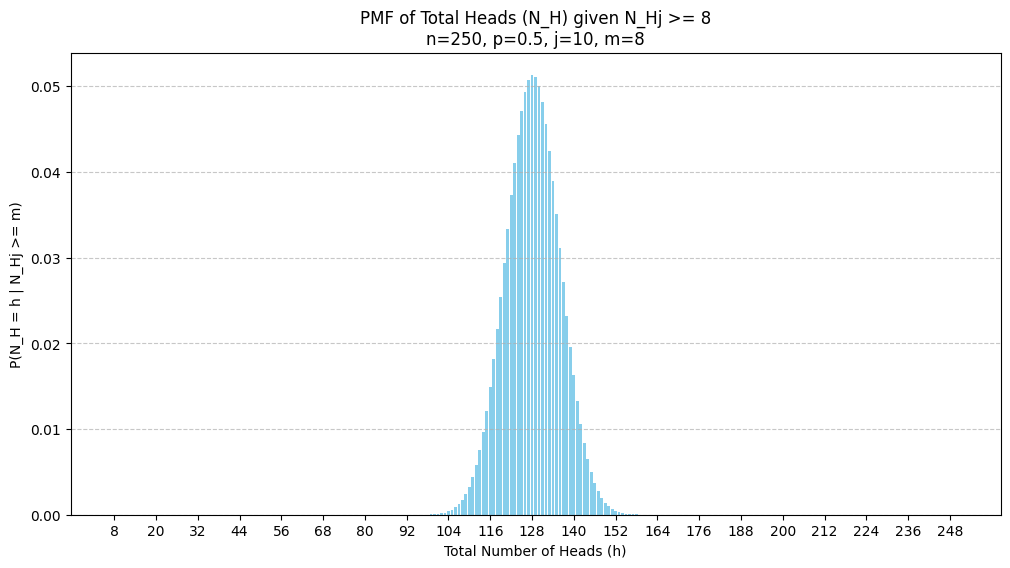


1b. Plotting PMF of N_H (using NEW plot_q1b_pmf_explicitly_truncated):
Generating TRUNCATED plot for Q1b PMF of N_H from h=95 to h=158


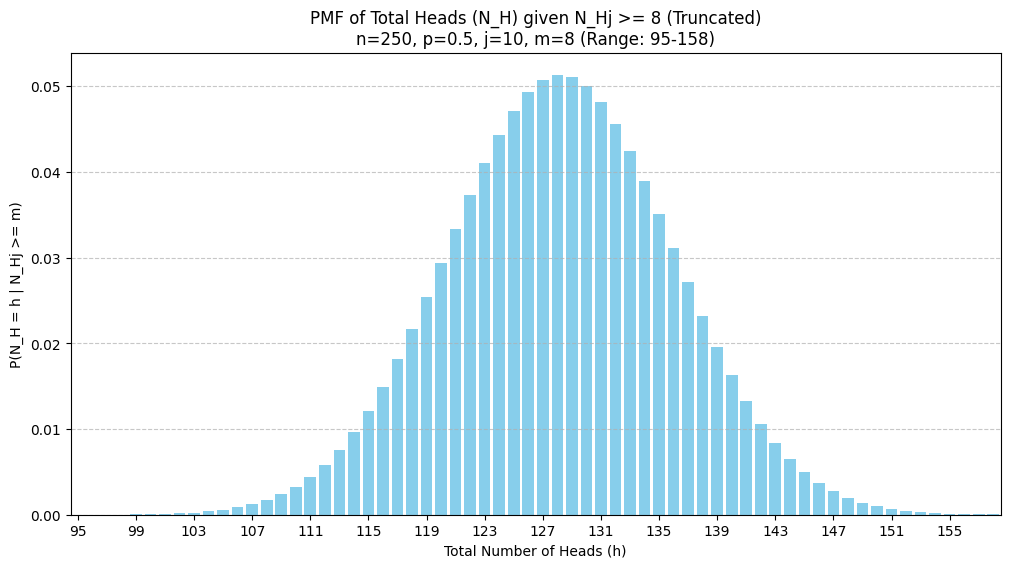


2a. Proof explanation for k* being even:
Proof that k* (flip number for a zero-crossing) must be even:
Let k* be the flip number at which a zero-crossing event S_k* = 0 occurs.
The state of the random walk is S_k* = H_k* - T_k*, where H_k* is the number of heads and T_k* is the number of tails in the first k* flips.
Alternatively, S_k* = 2*H_k* - k*.
A zero-crossing event means S_k* = 0.
So, 2*H_k* - k* = 0.
This implies k* = 2*H_k*.
Since H_k* (the number of heads) must be an integer, k* must be an integer multiple of 2.
Therefore, k* must be an even integer.

2b. Calculating P_Z (Probability of zero-crossing)... This might take a moment.
2b. Probability of zero-crossing P_Z: 0.679436

3a. Calculating E[t*|crossing] (Expected t* conditional on zero-crossing)... This might take a moment.
3a. Expected t* conditional on zero-crossing E[t*|crossing]: 65.7955
   Implied E[k*|crossing]: 75.7955

--- Demonstrating Q3b plotting functions ---

3b. Plotting PMF of t*


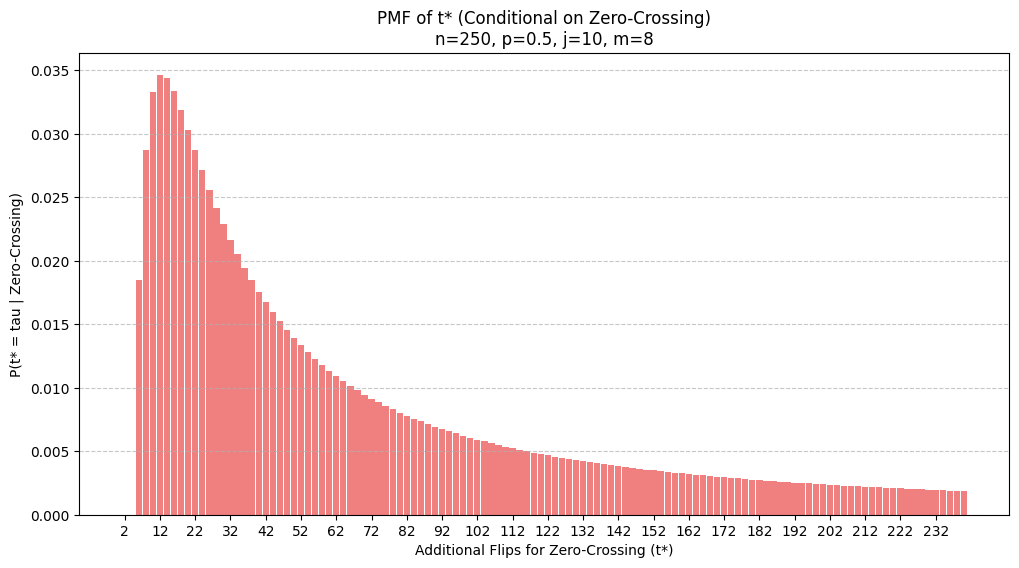


3b. Plotting PMF of k* (using NEW plot_q3b_pmf_explicitly_as_k_star, truncated k* range):
Generating plot for Q3b PMF of k* (total flips to zero-crossing).


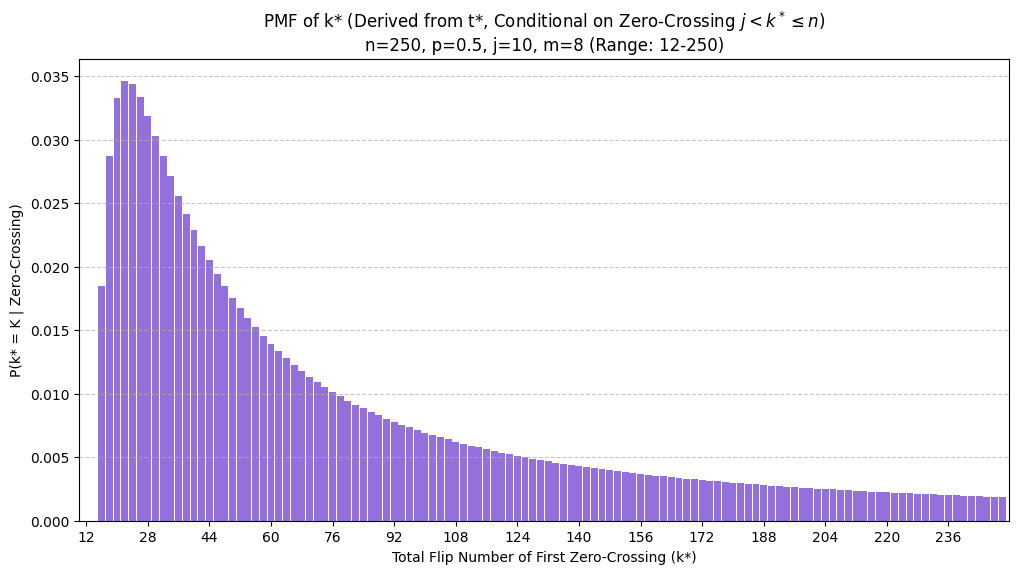


Test g(t'=2, A=0, p=0.5): 0.5
Test g(t'=4, A=0, p=0.5): 0.125
Test g(t'=6, A_target=-6, p=0.5) from example: 0.01562500000000012


In [25]:
# Parameters from the numerical example in the LaTeX document
n_example = 250
p_example = 0.5
m_example = 8
j_example = 10

print(f"--- Numerical Example Calculations (n={n_example}, p={p_example}, m={m_example}, j={j_example}) ---")

# --- Question 1 ---
expected_N_H = q1a_expected_total_heads(n_example, p_example, m_example, j_example)
print(f"\n1a. Expected total number of heads E[N_H|C]: {expected_N_H:.4f}") 

print("\n--- Demonstrating Q1b plotting functions ---")
# Using the USER-PROVIDED plot_q1b_distribution (plots full range)
print("\n1b. Plotting PMF of N_H:")
plot_q1b_distribution(n_example, p_example, m_example, j_example) # Full plot can be very wide

# Using the NEW plot_q1b_pmf_explicitly_truncated function
print("\n1b. Plotting PMF of N_H (using NEW plot_q1b_pmf_explicitly_truncated):")
h_plot_min_1b = 95
h_plot_max_1b = 158
plot_q1b_pmf_truncated(n_example, p_example, m_example, j_example, 
                                    h_plot_min=h_plot_min_1b, h_plot_max=h_plot_max_1b)


# --- Question 2 ---
print(f"\n2a. Proof explanation for k* being even:")
print(q2a_is_k_star_even_proof_explanation())

g_value_cache = {} 
print("\n2b. Calculating P_Z (Probability of zero-crossing)... This might take a moment.")
prob_Z = q2b_prob_zero_crossing(n_example, p_example, m_example, j_example, cache=g_value_cache)
print(f"2b. Probability of zero-crossing P_Z: {prob_Z:.6f}")


# --- Question 3 (Conditional on zero-crossing) ---
if prob_Z > 0: 
    print("\n3a. Calculating E[t*|crossing] (Expected t* conditional on zero-crossing)... This might take a moment.")
    expected_t_star = q3a_expected_t_star_conditional(n_example, p_example, m_example, j_example, cache=g_value_cache)
    print(f"3a. Expected t* conditional on zero-crossing E[t*|crossing]: {expected_t_star:.4f}")
    if not math.isnan(expected_t_star):
        print(f"   Implied E[k*|crossing]: {j_example + expected_t_star:.4f}")
    
    print("\n--- Demonstrating Q3b plotting functions ---")
    # Using the USER-PROVIDED plot_q3b_distribution (plots t*)
    print("\n3b. Plotting PMF of t*")
    plot_q3b_distribution(n_example, p_example, m_example, j_example, cache=g_value_cache) # Full t* plot

    # Using the NEW plot_q3b_pmf_explicitly_as_k_star function
    print("\n3b. Plotting PMF of k* (using NEW plot_q3b_pmf_explicitly_as_k_star, truncated k* range):")
    k_plot_max_3b_new = 250
    plot_q3b_pmf_as_k_star(n_example, p_example, m_example, j_example, cache=g_value_cache,
                                        k_plot_min=None, k_plot_max=k_plot_max_3b_new) # k_min_plot=None means use actual min k*
                                        
    # Example of plotting full range of k* with the new function
    # print("\n3b. Plotting PMF of k* (using NEW plot_q3b_pmf_explicitly_as_k_star, full range for k*):")
    # plot_q3b_pmf_explicitly_as_k_star(n_example, p_example, m_example, j_example, cache=g_value_cache)

else:
    print("\nSkipping Q3a and Q3b calculations as P_Z (probability of zero-crossing) is zero.")

# Test prob_first_passage_time for A=0 case: g(2,0,p=0.5)
print(f"\nTest g(t'=2, A=0, p=0.5): {prob_first_passage_time(2, 0, 0.5)}") 
print(f"Test g(t'=4, A=0, p=0.5): {prob_first_passage_time(4, 0, 0.5)}")
print(f"Test g(t'=6, A_target=-6, p=0.5) from example: {prob_first_passage_time(6, -6, 0.5)}")


# Overlay plots

In [48]:
def plot_empirical_vs_theoretical_q1b_truncated(
    empirical_h_values, empirical_probabilities,
    n_total_flips, p_head, m_min_heads_in_j, j_first_flips,
    h_plot_min=None, h_plot_max=None,
    csv_file_name="selected_trials.csv" # Added for context in title
    ):
    """
    Plots empirical distribution vs. theoretical PMF for N_H (from Q1b),
    with optional truncation of the plot range.

    Args:
        empirical_h_values (np.array): Array of N_H values from empirical data.
        empirical_probabilities (np.array): Corresponding probabilities from empirical data.
        n_total_flips (int): Total number of flips in the experiment.
        p_head (float): Probability of getting a head.
        m_min_heads_in_j (int): Minimum heads required in the first j_first_flips.
        j_first_flips (int): Number of initial flips for the condition.
        h_plot_min (int, optional): Minimum h value for plotting. Defaults to data min.
        h_plot_max (int, optional): Maximum h value for plotting. Defaults to data max.
        csv_file_name (str, optional): Name of the CSV file for plot title context.
    """

    # --- Theoretical Calculation using the imported function ---
    theoretical_pmf_dict = q1b_calculate_pmf_total_heads_distribution(
        n_total_flips, p_head, m_min_heads_in_j, j_first_flips
    )

    if not theoretical_pmf_dict:
        print("Theoretical PMF could not be calculated (P(C) might be zero). Aborting plot.")
        return

    h_values_theoretical_full = np.array(sorted(theoretical_pmf_dict.keys()))
    probabilities_theoretical_full = np.array([theoretical_pmf_dict[h] for h in h_values_theoretical_full])

    # --- Determine Plotting Range ---
    # If truncation limits are not provided, use the full range of available data.
    min_h_data = min(
        empirical_h_values.min() if len(empirical_h_values) > 0 else h_values_theoretical_full.min() if len(h_values_theoretical_full) > 0 else 0,
        h_values_theoretical_full.min() if len(h_values_theoretical_full) > 0 else (empirical_h_values.min() if len(empirical_h_values) > 0 else 0)
    )
    max_h_data = max(
        empirical_h_values.max() if len(empirical_h_values) > 0 else h_values_theoretical_full.max() if len(h_values_theoretical_full) > 0 else n_total_flips,
        h_values_theoretical_full.max() if len(h_values_theoretical_full) > 0 else (empirical_h_values.max() if len(empirical_h_values) > 0 else n_total_flips)
    )

    current_h_plot_min = h_plot_min if h_plot_min is not None else min_h_data
    current_h_plot_max = h_plot_max if h_plot_max is not None else max_h_data
    
    # --- Filter Data for Plotting based on Truncation ---
    # Empirical data
    if len(empirical_h_values) > 0:
        emp_indices_to_plot = (empirical_h_values >= current_h_plot_min) & (empirical_h_values <= current_h_plot_max)
        empirical_h_plot = empirical_h_values[emp_indices_to_plot]
        empirical_prob_plot = empirical_probabilities[emp_indices_to_plot]
    else:
        empirical_h_plot = np.array([])
        empirical_prob_plot = np.array([])

    # Theoretical data
    if len(h_values_theoretical_full) > 0:
        theo_indices_to_plot = (h_values_theoretical_full >= current_h_plot_min) & (h_values_theoretical_full <= current_h_plot_max)
        theoretical_h_plot = h_values_theoretical_full[theo_indices_to_plot]
        theoretical_prob_plot = probabilities_theoretical_full[theo_indices_to_plot]
    else:
        theoretical_h_plot = np.array([])
        theoretical_prob_plot = np.array([])

    # --- Plotting ---
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(14, 8))

    # Plot histogram from empirical data
    bar_width_empirical = 1.0
    if len(empirical_h_plot) > 1:
        diffs = np.diff(empirical_h_plot)
        if len(diffs) > 0 and np.all(diffs == diffs[0]) and diffs[0] > 0:
            bar_width_empirical = diffs[0] * 0.8
        else:
            bar_width_empirical = 1.0 * 0.8
    elif len(empirical_h_plot) == 1:
         bar_width_empirical = 0.8


    if len(empirical_h_plot) > 0:
        plt.bar(empirical_h_plot, empirical_prob_plot, 
                width=bar_width_empirical, 
                label=f'Empirical Distribution ($N_H$ from {csv_file_name})', 
                alpha=0.7, color='deepskyblue', edgecolor='black')

    # Plot theoretical PMF
    if len(theoretical_h_plot) > 0:
        plt.plot(theoretical_h_plot, theoretical_prob_plot, 
                 linestyle='-', marker='o', markersize=4,
                 label=f'Theoretical PMF ($N_H$ | $N_{{H,j={j_first_flips}}} \geq {m_min_heads_in_j}$)', 
                 alpha=0.35, color='crimson', linewidth=2)

    plt.xlabel(f'Total Number of Heads ($N_H$) in $n={n_total_flips}$ flips')
    plt.ylabel('Probability')
    trunc_info = ""
    if h_plot_min is not None or h_plot_max is not None:
        trunc_info = f" (Truncated Range: {current_h_plot_min}-{current_h_plot_max})"
    plt.title(f'Comparison of Empirical and Theoretical Distributions of $N_H${trunc_info}')
    
    if len(empirical_h_plot) > 0 or len(theoretical_h_plot) > 0:
        plt.legend()
    else:
        plt.text(0.5, 0.5, "No data to plot in the specified range.", ha='center', va='center', transform=plt.gca().transAxes)

    plt.grid(True, linestyle=':', alpha=0.9)
    
    # Adjust x-limits for the truncated plot
    plt.xlim([current_h_plot_min - bar_width_empirical, current_h_plot_max + bar_width_empirical])
    plt.ylim(bottom=0)

    plt.show()
    # To save:
    # plt.savefig(f'nh_comparison_truncated_{current_h_plot_min}_{current_h_plot_max}.png', dpi=300)
    # print(f"Plot saved as nh_comparison_truncated_{current_h_plot_min}_{current_h_plot_max}.png")




--- Plotting with automatic full range ---


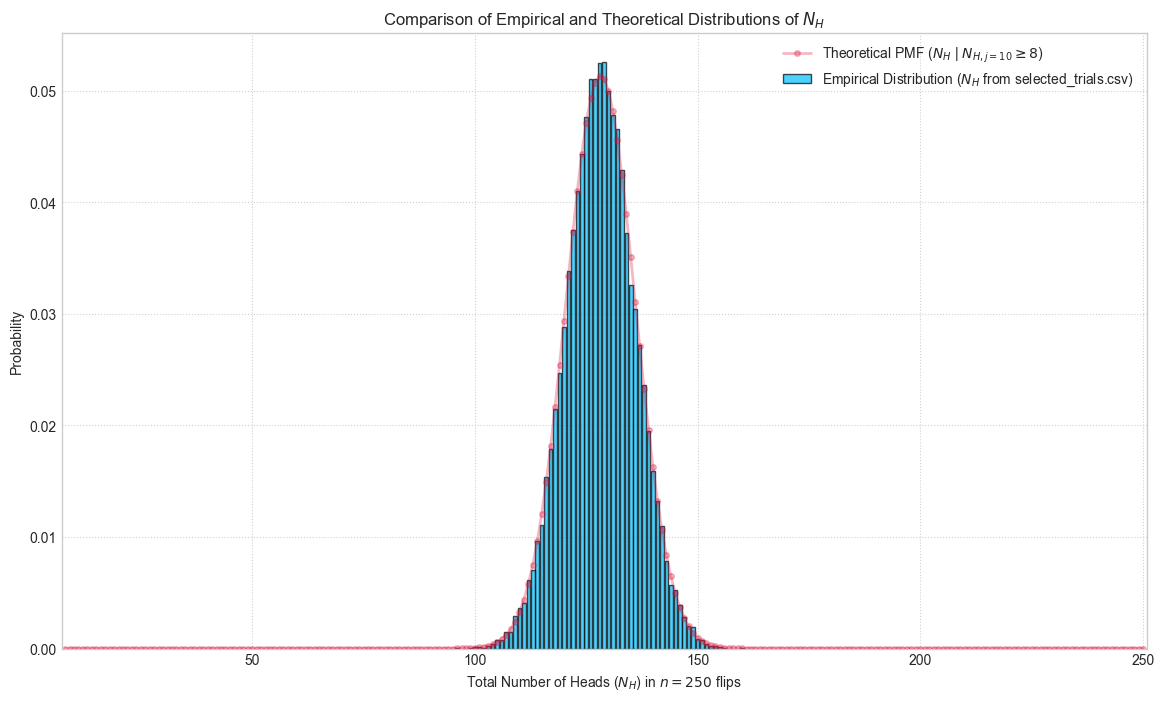


--- Plotting with truncation based on empirical range (96 to 160) ---


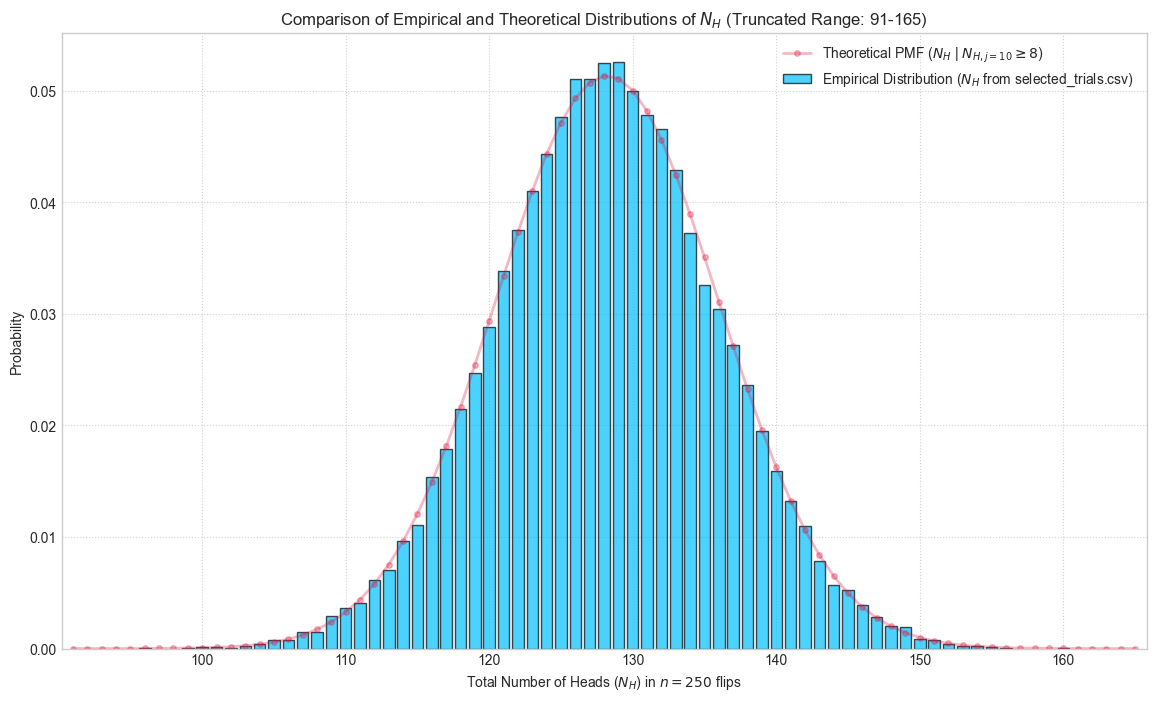

In [ ]:
import pandas as pd
csv_file_name = 'selected_trials.csv'
try:
    df_empirical = pd.read_csv(csv_file_name)
    empirical_h_values_main = df_empirical['Heads'].values
    empirical_percentages_main = df_empirical['Percentage'].values
except (FileNotFoundError, pd.errors.EmptyDataError, KeyError) as e:
    print(f"Warning: Could not read or parse '{csv_file_name}' ({e}). Using placeholder data.")
    # Placeholder data
    empirical_h_values_main = np.array([110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140]) # More typical N_H values
    empirical_percentages_main = np.array([0.1, 0.5, 1.0, 2.0, 3.5, 5.0, 6.5, 7.5, 7.0, 6.0, 4.5, 3.0, 1.5, 0.8, 0.4, 0.2]) # Example percentages

# Convert empirical percentages to probabilities
empirical_probabilities_main = empirical_percentages_main / 100.0

# Parameters for the theoretical model (from LaTeX numerical example)
n_total_flips_main = 250
p_head_main = 0.5
m_min_heads_j_main = 8
j_first_flips_main = 10

# --- Call the new plotting function ---

# Example 2: Plotting full range (by not providing h_plot_min and h_plot_max)
print("\n--- Plotting with automatic full range ---")
plot_empirical_vs_theoretical_q1b_truncated(
    empirical_h_values=empirical_h_values_main,
    empirical_probabilities=empirical_probabilities_main,
    n_total_flips=n_total_flips_main,
    p_head=p_head_main,
    m_min_heads_in_j=m_min_heads_j_main,
    j_first_flips=j_first_flips_main,
    h_plot_min=None, # Explicitly None for full range
    h_plot_max=None, # Explicitly None for full range
    csv_file_name=csv_file_name
)

# Example 3: Plotting with different truncation based on empirical data if it's very sparse
if len(empirical_h_values_main) > 0:
    emp_min = empirical_h_values_main.min()
    emp_max = empirical_h_values_main.max()
    print(f"\n--- Plotting with truncation based on empirical range ({emp_min} to {emp_max}) ---")
    plot_empirical_vs_theoretical_q1b_truncated(
        empirical_h_values=empirical_h_values_main,
        empirical_probabilities=empirical_probabilities_main,
        n_total_flips=n_total_flips_main,
        p_head=p_head_main,
        m_min_heads_in_j=m_min_heads_j_main,
        j_first_flips=j_first_flips_main,
        h_plot_min=emp_min-5, 
        h_plot_max=emp_max+5,
        csv_file_name=csv_file_name
    )

In [ ]:
# --- Plotting Function for Q3b (k*) Overlay ---
def plot_empirical_vs_theoretical_q3b_k_star_truncated(
    empirical_k_star_values, empirical_k_star_probabilities,
    n_total_flips, p_head, m_min_heads_in_j, j_first_flips,
    k_plot_min=None, k_plot_max=None,
    cache=None, # Pass cache for theoretical calculations
    csv_file_name="zero_crossing_trials.csv"
    ):
    """
    Plots empirical distribution vs. theoretical PMF for k* (from Q3b derived),
    with optional truncation of the plot range.
    """
    if cache is None: cache = {}

    # theoretical_k_star_pmf_dict = q3b_calculate_pmf_k_star_conditional_distribution(
    #     n_total_flips, p_head, m_min_heads_in_j, j_first_flips, cache=cache
    # )

    theoretical_k_star_pmf_dict = q3b_calculate_pmf_t_star_conditional_distribution(
        n_total_flips, p_head, m_min_heads_in_j, j_first_flips, cache=cache
    )

    theoretical_k_star_pmf_dict = {k + j_first_flips: v for k, v in theoretical_k_star_pmf_dict.items()} # change from t* to k*

    if not theoretical_k_star_pmf_dict:
        print("Theoretical PMF for k* could not be calculated (P_Z might be zero). Aborting plot.")
        return

    k_values_theoretical_full = np.array(sorted(theoretical_k_star_pmf_dict.keys()))
    probabilities_theoretical_full = np.array([theoretical_k_star_pmf_dict[k] for k in k_values_theoretical_full])
    
    min_k_data = j_first_flips # k* must be > j
    max_k_data = n_total_flips
    if len(empirical_k_star_values) > 0 and len(k_values_theoretical_full) > 0:
        min_k_data = min(empirical_k_star_values.min(), k_values_theoretical_full.min())
        max_k_data = max(empirical_k_star_values.max(), k_values_theoretical_full.max())
    elif len(empirical_k_star_values) > 0:
        min_k_data = empirical_k_star_values.min()
        max_k_data = empirical_k_star_values.max()
    elif len(k_values_theoretical_full) > 0:
        min_k_data = k_values_theoretical_full.min()
        max_k_data = k_values_theoretical_full.max()


    current_k_plot_min = k_plot_min if k_plot_min is not None else min_k_data
    current_k_plot_max = k_plot_max if k_plot_max is not None else max_k_data

    emp_indices_to_plot = (empirical_k_star_values >= current_k_plot_min) & (empirical_k_star_values <= current_k_plot_max)
    empirical_k_plot = empirical_k_star_values[emp_indices_to_plot]
    empirical_k_prob_plot = empirical_k_star_probabilities[emp_indices_to_plot]

    theo_indices_to_plot = (k_values_theoretical_full >= current_k_plot_min) & (k_values_theoretical_full <= current_k_plot_max)
    theoretical_k_plot = k_values_theoretical_full[theo_indices_to_plot]
    theoretical_k_prob_plot = probabilities_theoretical_full[theo_indices_to_plot]

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(14, 8))

    bar_width_empirical = 1.6 
    if len(empirical_k_plot) > 1:
        diffs = np.diff(empirical_k_plot)
        if len(diffs) > 0 and np.all(diffs > 0) and np.all(diffs % 2 == 0):
             if np.all(diffs == diffs[0]):
                  bar_width_empirical = diffs[0] * 0.8
             else: 
                  bar_width_empirical = 1.6 
    elif len(empirical_k_plot) == 1: bar_width_empirical = 0.8


    if len(empirical_k_plot) > 0:
        plt.bar(empirical_k_plot, empirical_k_prob_plot, width=bar_width_empirical,
                label=f'Empirical $k^*$ (from {csv_file_name})', alpha=0.7, color='mediumpurple', edgecolor='black')

    if len(theoretical_k_plot) > 0:
        plt.plot(theoretical_k_plot, theoretical_k_prob_plot, linestyle='-', marker='o', markersize=4,
                 label=f'Theoretical $k^*$ | $N_{{H,j={j_first_flips}}} \geq {m_min_heads_in_j}$', color='darkorange', linewidth=2)

    plt.xlabel(f'Flip Number of First Zero-Crossing ($k^*$) (after $j={j_first_flips}$ flips)')
    plt.ylabel('Probability')
    trunc_info = f" (Range: {current_k_plot_min}-{current_k_plot_max})" if k_plot_min is not None or k_plot_max is not None else ""
    plt.title(f'Comparison: Empirical vs Theoretical $k^*$ Distribution{trunc_info}')
    
    if len(empirical_k_plot) > 0 or len(theoretical_k_plot) > 0: plt.legend()
    else: plt.text(0.5, 0.5, "No data to plot in the specified range for k*.", ha='center', va='center', transform=plt.gca().transAxes)
        
    plt.grid(True, linestyle=':', alpha=0.9)
    
    # Adjust x-ticks for better readability
    # Aim for around 20-25 ticks if the range is wide enough
    num_plot_points = len(theoretical_k_plot) # Use theoretical points as they are usually denser
    if not num_plot_points and len(empirical_k_plot): # Fallback to empirical if theoretical is empty
        num_plot_points = len(empirical_k_plot)

    if num_plot_points > 0:
        target_ticks = 25 # Desired number of ticks
        if num_plot_points <= target_ticks:
            # If fewer unique points than target, show all of them if they are not too close
            # For k*, values are even, so direct plotting of theoretical_k_plot is usually fine
            # if the number of points is small.
            unique_ticks_to_show = np.unique(np.concatenate((theoretical_k_plot, empirical_k_plot)))
            unique_ticks_to_show = unique_ticks_to_show[(unique_ticks_to_show >= current_k_plot_min) & (unique_ticks_to_show <= current_k_plot_max)]
            if len(unique_ticks_to_show) <= target_ticks + 5 : # Allow a bit more if they are all distinct
                 plt.xticks(np.unique(unique_ticks_to_show), rotation=0, ha="center")
            else: # Too many unique points even if num_plot_points was small, so step
                step = max(1, len(unique_ticks_to_show) // target_ticks)
                plt.xticks(unique_ticks_to_show[::step], rotation=0, ha="center")

        else: # More points than target, calculate a step
            # Use the actual values present in theoretical_k_plot for ticks
            step = max(1, num_plot_points // target_ticks)
            plt.xticks(theoretical_k_plot[::step], rotation=0, ha="center")
    
    plt.xlim([current_k_plot_min - bar_width_empirical, current_k_plot_max + bar_width_empirical]) 
    plt.ylim(bottom=0)
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show()


--- Plotting k* Distribution (derived from Q3b) - Full Range ---


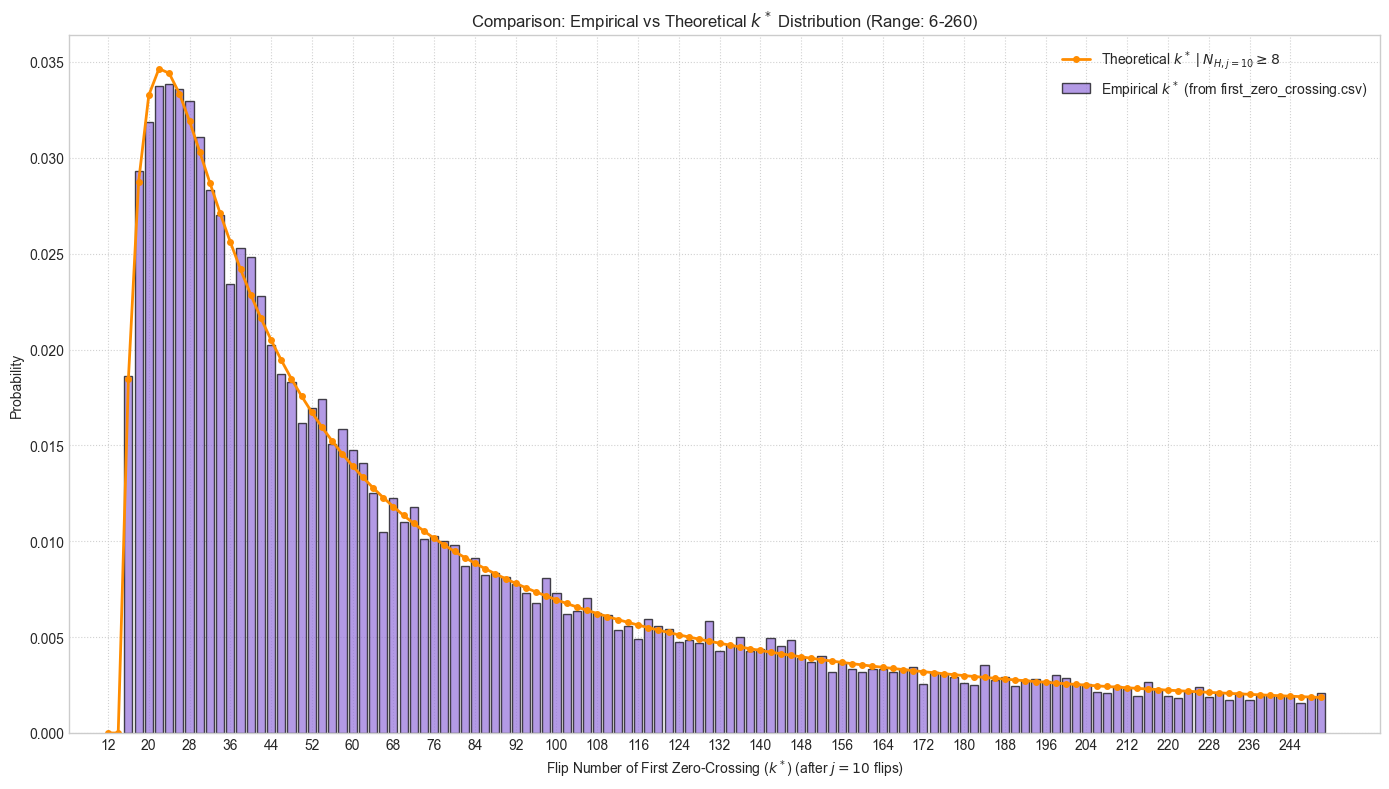


--- Plotting k* Distribution (derived from Q3b) - Truncated ---


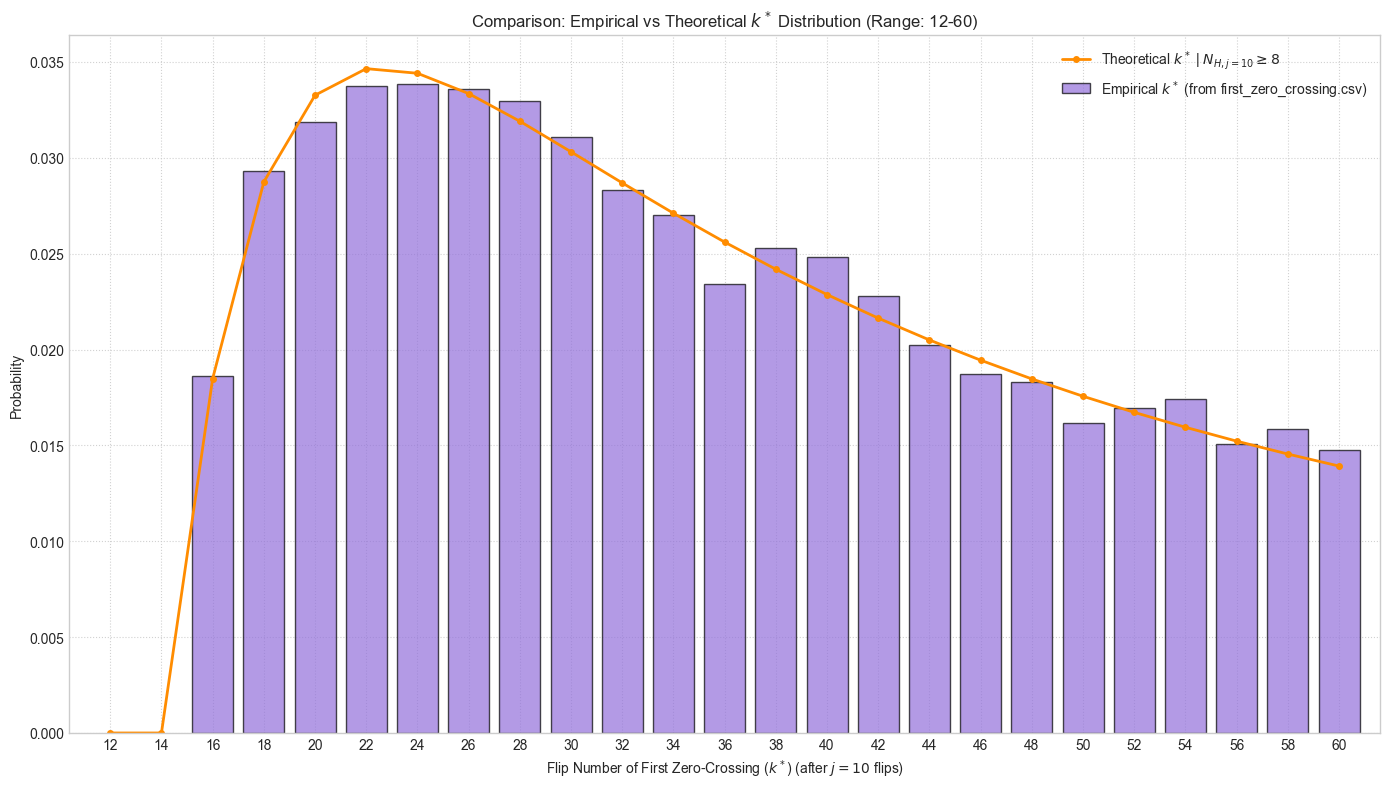

In [ ]:
import pandas as pd
# --- Plotting for k* (First Zero-Crossing, derived from Q3b) ---
csv_file_name_k_star = 'first_zero_crossing.csv' # Assumed CSV name for k* data
try:
    df_empirical_k_star = pd.read_csv(csv_file_name_k_star)
    empirical_k_star_values_main = df_empirical_k_star['first_zero_position'].values 
    empirical_k_star_percentages_main = df_empirical_k_star['Percentage'].values
except (FileNotFoundError, pd.errors.EmptyDataError, KeyError) as e:
    print(f"Warning: Could not read or parse k* data from '{csv_file_name_k_star}' ({e}). Using placeholder k* data.")
    # Placeholder k* data (k* must be > j_first_flips and even)
    empirical_k_star_values_main = np.array([16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40]) 
    empirical_k_star_percentages_main = np.array([1.8, 2.9, 3.2, 3.4, 3.3, 3.1, 2.8, 2.5, 2.1, 1.7, 1.2, 0.8, 0.5])
empirical_probabilities_main_k_star = empirical_k_star_percentages_main / 100.0


emp_min = empirical_k_star_values_main.min() 
emp_max = empirical_k_star_values_main.max()


print("\n--- Plotting k* Distribution (derived from Q3b) - Full Range ---")
plot_empirical_vs_theoretical_q3b_k_star_truncated(
    empirical_k_star_values=empirical_k_star_values_main,
    empirical_k_star_probabilities=empirical_probabilities_main_k_star,
    n_total_flips=n_total_flips_main,
    p_head=p_head_main,
    m_min_heads_in_j=m_min_heads_j_main,
    j_first_flips=j_first_flips_main,
    k_plot_min=emp_min-10, k_plot_max=emp_max+10, # Example: full range with some padding
    cache=g_value_cache,
    csv_file_name=csv_file_name_k_star
)


# Example of truncated k* plot
print("\n--- Plotting k* Distribution (derived from Q3b) - Truncated ---")
plot_empirical_vs_theoretical_q3b_k_star_truncated(
    empirical_k_star_values=empirical_k_star_values_main,
    empirical_k_star_probabilities=empirical_probabilities_main_k_star,
    n_total_flips=n_total_flips_main,
    p_head=p_head_main,
    m_min_heads_in_j=m_min_heads_j_main,
    j_first_flips=j_first_flips_main,
    k_plot_min=None, k_plot_max=60, # Example: full min, max up to 60
    cache=g_value_cache, # Pass the cache
    csv_file_name=csv_file_name_k_star
)